In [1]:
import numpy as np
from scipy.cluster import hierarchy, vq
import math
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.gridspec import GridSpec

np.set_printoptions(precision=5, suppress=True)

# Flock Extraction
### Analysis of an individual-based model
## Jasmine Otto, UIC

In [2]:
from boids import Sim

## A flocking
* First, three flocks.
* Second, three flocks, but one merges in.

In [72]:
np.random.seed(4)
# np.random.seed(0)

# make_ring(40): {0: three flocks diverge, 1: three merge, 4: one breakaway}

def make_ring(N):
    state = np.zeros([N, 4])
    theta = np.random.uniform(-np.pi,np.pi,N)

    # completely coinciding boids won't go anywhere
    state[:,0:2] = np.stack([np.cos(theta), np.sin(theta)], axis=1)
    # just face outwards
    state[:,2:4] = state[:, 0:2]
    return state

pars = dict(separate=2.5, align=1.5, cohere=1,
           steer = .1, speed = 1)
maxT = 80

ics = make_ring(30) # 80
sim = Sim(ics, pars, maxT)
sim.run()

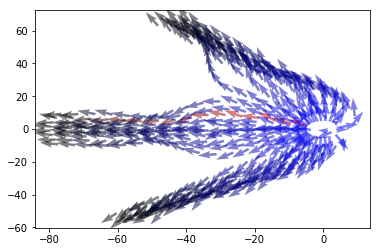

In [73]:
zoomOut = 5
for t in range(maxT//zoomOut):
    i = t*zoomOut
    # unpack columns: stackoverflow.com/a/27047043
    plt.quiver(*sim.report(maxT-1-i)[0, :].T, # -i, :, :
               color = [[i/maxT,0,0] for j in range(5)], alpha=.5)
    
    plt.quiver(*sim.report(maxT-1-i)[1:, :].T,
               color = [[0,0,i/maxT] for j in range(5)], alpha=.5)

# Label flocks

In [74]:
def hud(X, W, figsize=(12, 4)):
    # plot X with labels W, in literal space and with headings only.
    plt.figure(figsize=figsize)
    theta = np.arctan2(X[:,3], X[:,2])

    plt.subplot(1,2,2); # easier than axis wrangling: stackoverflow.com/a/42818547
    plt.scatter(0,0, c='black') # center the unit circle

    k = int(np.ptp(W) + 1) # infer k from labelling
    for i,c in zip(range(k), cm.rainbow(np.linspace(.1,.9,k))):
        js = np.where(W==i+1)
        
        plt.subplot(1,2,1); plt.quiver(*X[js].T, color=c)
        plt.subplot(1,2,2); plt.scatter(np.cos(theta[js]), np.sin(theta[js]), c=c)

def den(X, W, Z, figsize=(12, 4)):
    # plot X with labels W, in literal space and with headings only.
    plt.figure(figsize=figsize)

    k = int(np.ptp(W) + 1)
    plt.subplot(1,2,1)
    for i,c in zip(range(k), cm.rainbow(np.linspace(.1,.9,k))):
        js = np.where(W==i+1)    
        plt.quiver(*X[js].T, color=c)
        
    plt.subplot(1,2,2)
    R = hierarchy.dendrogram(Z, show_leaf_counts=False, count_sort=True,
                             truncate_mode='level', p=3,
                             color_threshold=0.05, show_contracted=True)
    plt.subplot(1,2,1)
    for i in R['ivl']: # range(X.shape[0]):
        if i: plt.annotate(i, xy=X[int(i), 0:2])
            
def seek(s, k, candidates):
    best = math.inf; ret = None
    for t in candidates:
        labels, Z = cluster(s, t, k, True)
        loss = np.sum(Z[:-k:-1, 2])
        print('{}: marginal loss: {} | {}'
              .format(t, Z[:-k:-1, 2], round(loss, 4)) )
        if loss < best:
            best = loss; ret = labels, t, Z
    return ret

## Predictive value?

cluster at t = 35 | view at t = (35, 55, 80)


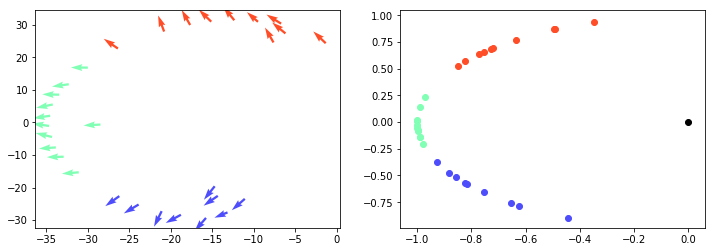

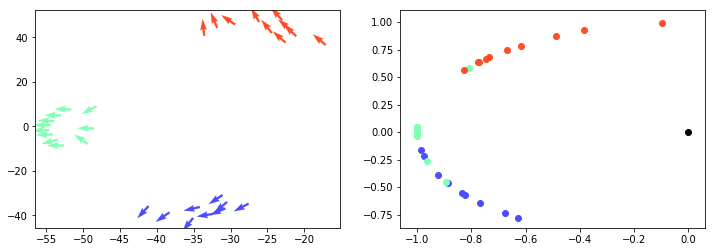

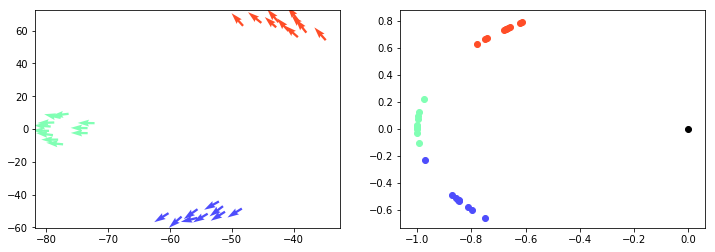

In [77]:
def cluster(s, t, k, dendrogram=None):
    # k-cluster s, a Sim, at time t.
    # (euclidian metric isn't especially faithful to 2d + 1d periodic spaces)
    
    state = s.report(t)
    theta = np.arctan2(state[:,3], state[:,2])
    # dth = theta - np.roll(theta, 3); print(dth) # representative theta diffs

    raw = state[:, 0:2] # 'normalize' positions, so they don't swamp orientation
    # X = vq.whiten(raw)
    shift = np.average(raw, axis=0)
    X = (raw - shift) / np.ptp(raw, axis=0) + shift

    # Th = np.vstack([theta, labels]); Th.sort(axis=1); Th
    def phasepolar(x,y): # polar in third coord (fixed speed)
        dx = x[0]-y[0]; dy = x[1]-y[1]
        dth = abs(x[2] - y[2]) / math.pi
        if dth > 1: dth = 2 - dth # careful!
        return dx*dx + dy*dy + dth*dth # CLAIM: discarding alignment trivializes
    
    X = np.hstack([X, theta.reshape(-1,1)])
    Z = hierarchy.linkage(X, metric=phasepolar)
    # joernhees.de/blog/2015/08/26/
    # scipy-hierarchical-clustering-and-dendrogram-tutorial/
    
    labels = hierarchy.fcluster(Z, k, criterion='maxclust')
    if dendrogram: return labels, Z
    return labels

k = 3; peekIdx = 35
# labels, peekIdx, Z = seek(sim, k, [peekIdx+i-5 for i in range(11)])
labels, Z = cluster(sim, peekIdx, k, True)

viewIdxs = 35, 55, 80
print('cluster at t =', peekIdx, '| view at t =', viewIdxs)

for t in viewIdxs:
    hud(sim.report(t-1), labels)

### Loss versus oracle
Were our labels predictive?

predictions changed: 0/30


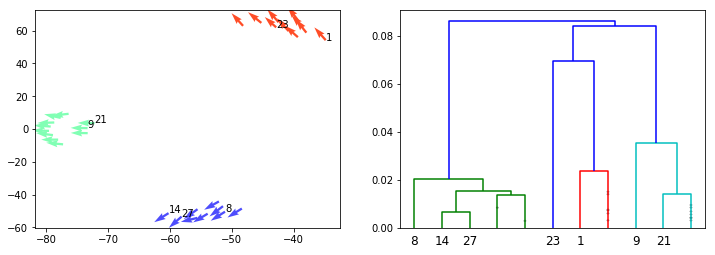

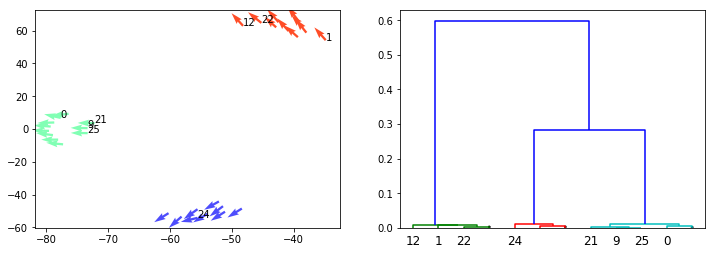

In [78]:
def bestCluster(s, t, ref, dendrogram=None):
    # try to match the old indexing. return most optimistic k-elem permutation.
    k = int(np.ptp(ref)+1)
    guess, Z = cluster(sim, t, k, dendrogram)

    k_ = math.factorial(k)
    codes = [v for v in itertools.permutations(range(k+1,2*k+1), k)]
        # use k+range(k) as swap space for per-symbol replacement.

    res = np.vstack([guess for i in range(k_)])
    for i in range(k_):
        for j in range(k):
            np.place(res[i], res[i] == j+1, codes[i][j])
        res[i] -= k # leave swap space

    loss = np.count_nonzero(np.not_equal(res, ref), axis=1)
    ret = res[np.argmin(loss)]
    
    if dendrogram: return ret, loss, Z
    return ret, loss

W,Z = cluster(sim, peekIdx, k, dendrogram=True)
den(sim.report(maxT-1), W, Z)
# What if we relabel at current moment?

relabeled, ns, Z = bestCluster(sim, maxT-1, labels, True)
den(sim.report(maxT-1), relabeled, Z)

print('predictions changed: {}/{}'.format(np.min(ns), sim.pop))
# marginal cluster loss: {}''', Z[:-5:-1, 2]))

### Broad strokes
What if we model flocks by ellipses?

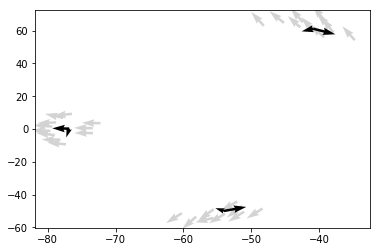

In [79]:
# fit imposter
# https://dsp.stackexchange.com/a/2290

def approxFlock(X, W):
    k = int(np.ptp(W)+1)
    for i in range(k):
        flockRaw = X[np.where(W==i+1)]
        centroid = np.average(flockRaw[:,0:2], axis=0) # ignore velocity

        flock = flockRaw[:,0:2] - centroid
        scatter = np.dot(flock.T, flock)
        lam, rot = np.linalg.eig(scatter)

        if lam[1]>lam[0]: rot = np.fliplr(rot) # sort eigenvectors
        tf = np.vstack([centroid, centroid])

        if flock.shape[0] > 1:
            std = np.dot(np.linalg.inv(rot), flock.T).std(axis=1)
            # print( 2/np.sqrt(lam), std) # FIX magnitude :/
            
            res = np.hstack([tf, (rot * std).T])
            plt.quiver(*res.T, angles='xy', scale_units='xy', scale=1)
    
plt.quiver(*sim.report(maxT-1).T, color='lightgray')
approxFlock(sim.trace[maxT-1], relabeled)

## Attractor basin

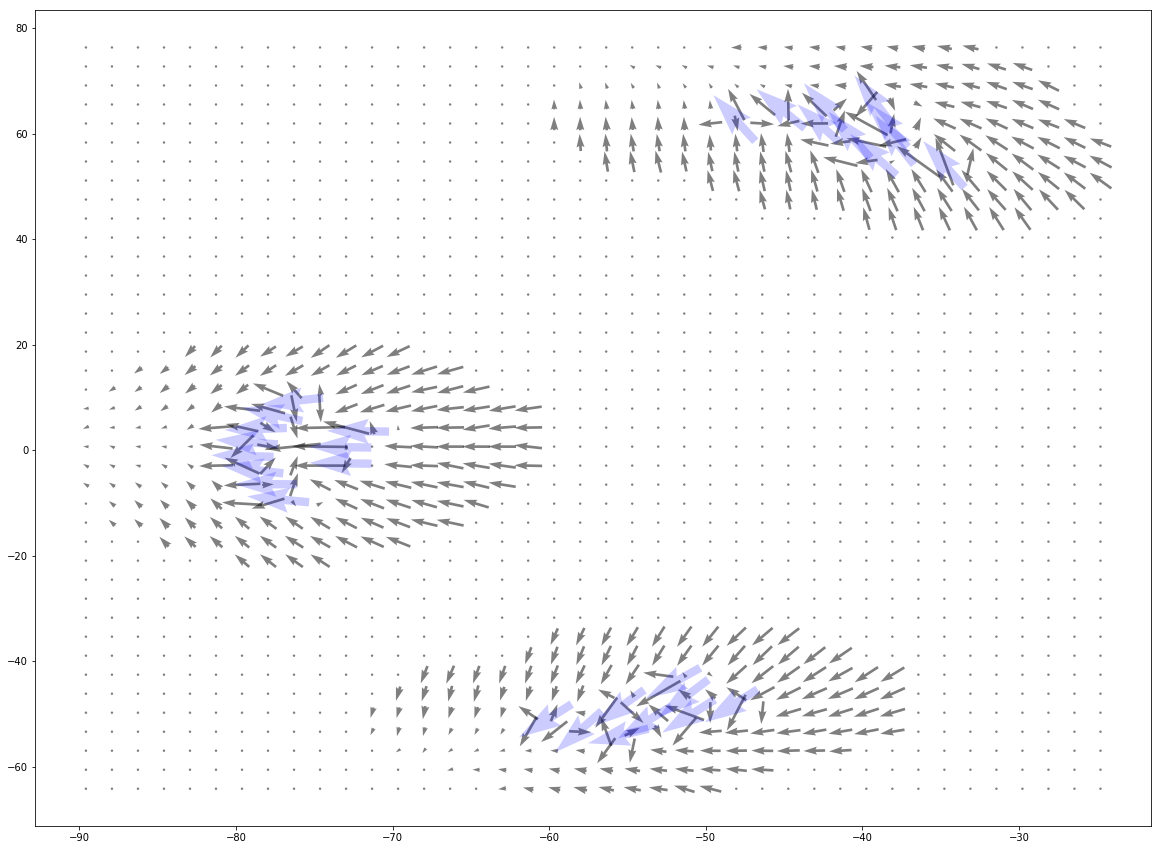

In [80]:
xmin, ymin = sim.trace[maxT-1, :].min(axis=0)[0:2]
xmax, ymax = sim.trace[maxT-1, :].max(axis=0)[0:2]

res = 40; pad = 10
view = (xmin-pad, xmax+pad,
        ymin-pad, ymax+pad, res, res)

def phasegrid(minX, maxX, minY, maxY,
              resX, resY, vx=0, vy=0,):
    xs = np.linspace(minX, maxX, resX)
    ys = np.linspace(minY, maxY, resY)
    n = resX*resY

    xv,yv = np.meshgrid(xs, ys)
    return np.hstack( [xv.reshape(-1,1), yv.reshape(-1,1),
                        vx * np.ones((n,1)), vy * np.ones((n,1))] )

plain = phasegrid(*view, 0, 0)
plt.figure(figsize=(20, 15))
plt.quiver(*sim.field(maxT-1, plain).T, alpha = .5, scale=10, pivot='mid')

plt.quiver(*sim.report(maxT-1).T, color='blue', alpha=.2, pivot='mid');

In [81]:
# let's zoom in on a single cluster.
which = 3
piece = cluster(sim, maxT - 1, 3)

rnd = .5 # coarseness of scaffold to fit boid positions onto
anchors = np.around( sim.trace[maxT-1,
                               np.where(piece == which),
                               0:2][0]*rnd, 0) / rnd

breadth = 11
stencil = [] # diamond stencil with scaffold's coarseness
for i in range(breadth):
    for j in range(breadth - i):
        stencil += [[0,0]] if i is 0 and j is 0 else\
                   [[i,0],[-i,0]] if j is 0 else\
                   [[0,j],[0,-j]] if i is 0 else\
                   [[i,j], [-i,j], [i,-j], [-i,-j]]
stencil = rnd * np.array(stencil)
print(stencil.shape)

samples = np.zeros((anchors.shape[0], stencil.shape[0], 2))
for i in range(stencil.shape[0]):
    samples[:,i,:] = anchors + stencil[i]

# merge stencils
samplingRaw = samples.reshape((-1,2))
sampling = np.unique(samplingRaw, axis=0)
print( samplingRaw.shape,  sampling.shape)

(221, 2)
(2431, 2) (1229, 2)


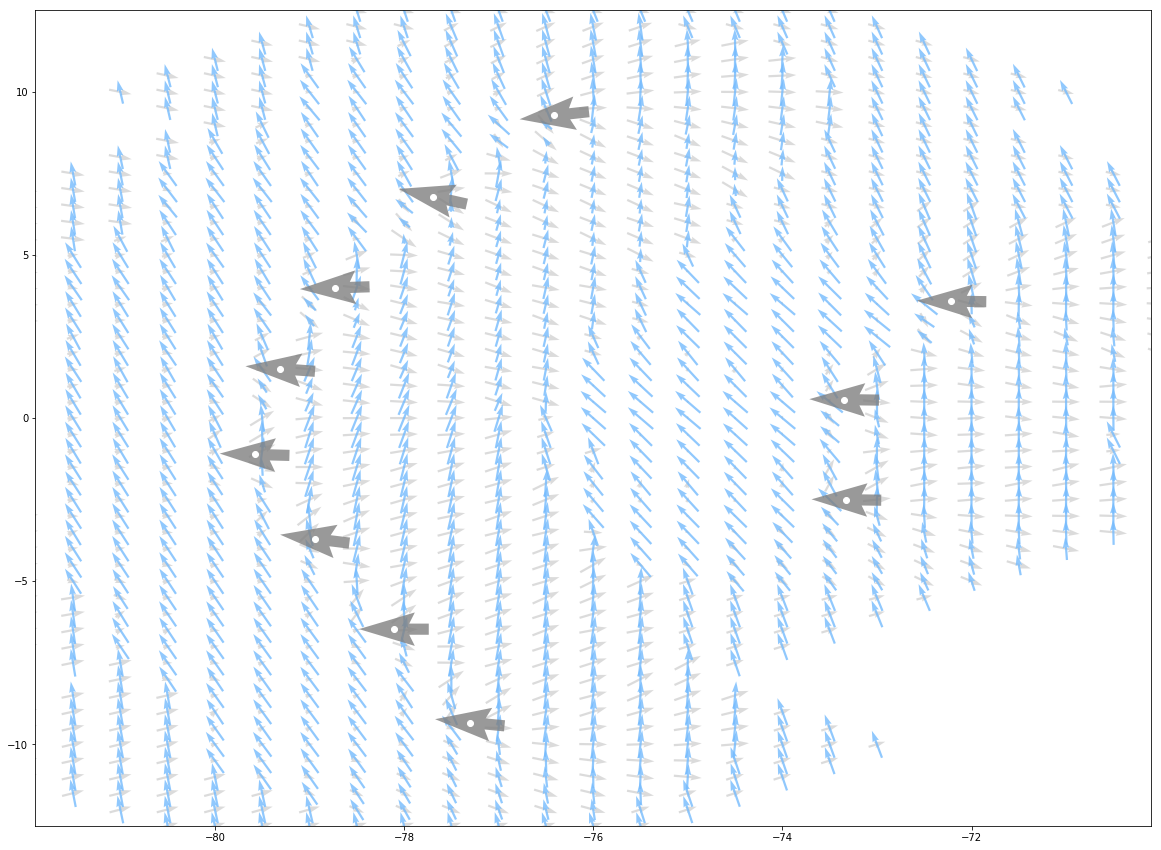

In [82]:
# enforce: orthogonal unit vectors (crosscurrents)
H = [1,0]
V = [0,1]

n = sampling.shape[0]
velH = np.repeat([H], n, axis=0)
horz = np.hstack([sampling, velH])

velV = np.repeat([V], n, axis=0)
vert = np.hstack([sampling, velV])

# mix in part of the pre-existing travel vector
c = .5
fH = sim.field(maxT-1, horz) + c*np.array([[0,0] + H])
fV = sim.field(maxT-1, vert) + c*np.array([[0,0] + V])

plt.figure(figsize=(20, 15))
# ax = plt.gca(); ax.set_facecolor('lightgray')

fieldOpts = dict(alpha=.8, pivot='mid', scale=20, width=.002)

plt.quiver(*fH.T, color='lightgray', **fieldOpts)
plt.quiver(*fV.T, color='xkcd:sky blue', **fieldOpts)

boids = sim.trace[maxT-1, np.where(piece==which), :][0]
plt.quiver(*boids.T, pivot='mid', color='gray', alpha=.8,
                       scale=16, width=.01)
plt.scatter(*boids[:,0:2].T, color='white');

ymin, ymax = plt.ylim(); plt.ylim(ymin+4, ymax-4);
xmin, xmax = plt.xlim(); plt.xlim(xmin+4, xmax-4);

In [83]:
# vector field metrics?
# https://stackoverflow.com/a/39558950

## Parameter variation

In [84]:
def flower():
    gs = GridSpec(7,8); plt.figure(figsize=(16,12))
    axs = [None for i in range(7)]
    axs[0] = plt.subplot(gs[2:5, 2:6])
    # 12 o'clock - 6
    axs[1] = plt.subplot(gs[0:2, 3:5]); axs[2] = plt.subplot(gs[5:7, 3:5])
    # 2 o'clock - 8
    axs[3] = plt.subplot(gs[1:3, 6:8]); axs[4] = plt.subplot(gs[4:6, 0:2])
    # 4 o'clock - 10
    axs[5] = plt.subplot(gs[4:6, 6:8]); axs[6] = plt.subplot(gs[1:3, 0:2])
    return axs

# OVERRIDE 
pars['separate'] = 2.5
pars['align'] = 1.5
pars['cohere'] = 1

experiment = [('align', .2), ('align', -.2),
              ('separate', .2), ('separate', -.2),
              ('cohere', .2), ('cohere', -.2)]

result = [None for i in range(7)]
result[0] = sim
for i,(k,v) in enumerate(experiment):
    pert = dict(pars); pert[k] += v
    
    perturb = Sim(ics, pert, maxT); perturb.run()
    result[i+1] = perturb

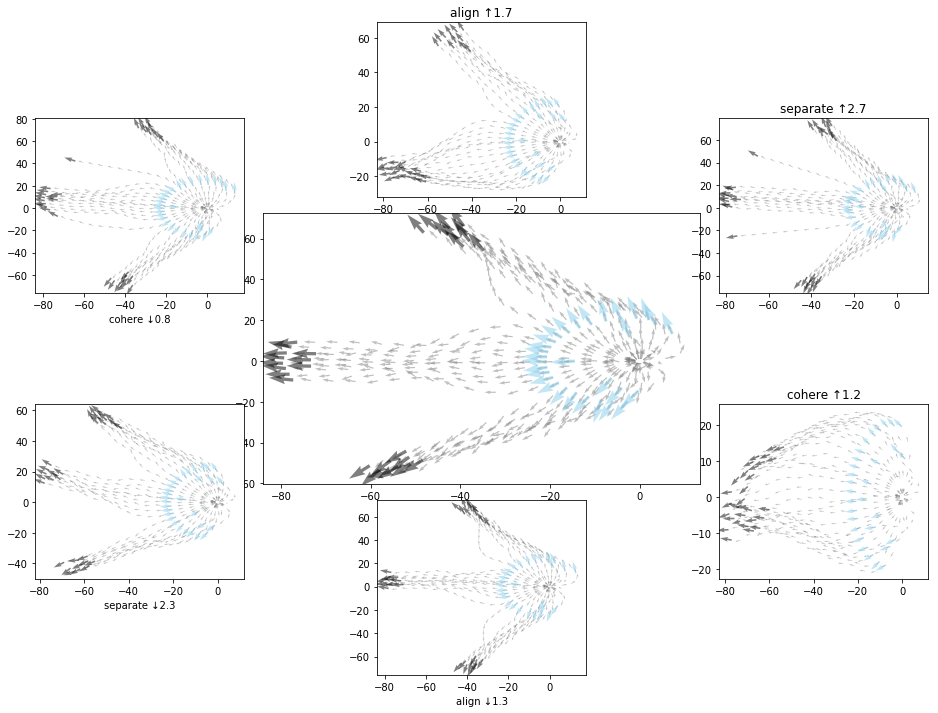

In [85]:
peekIdx = 20

def describe(i):
    if i is 0: return '' # 'base case'
    
    k,v = experiment[i-1]
    arrow = '↑' if v > 0 else '-' if v is 0 else '↓'
    return '{} {}{}'.format(k, arrow, pars[k]+v)

axs = flower()
for i in range(7):
    if i in [2,4,6]: axs[i].set_xlabel(describe(i))
    else: axs[i].set_title(describe(i))
        
    axs[i].quiver(*result[i].trace[0:maxT:5, :,:].T, color='gray', alpha=.5)
    axs[i].quiver(*result[i].trace[peekIdx, :,:].T, color='skyblue', alpha=.5)
    axs[i].quiver(*result[i].trace[maxT-1, :,:].T, alpha=.5)

### Too many boids
Let's summarize by clusters.

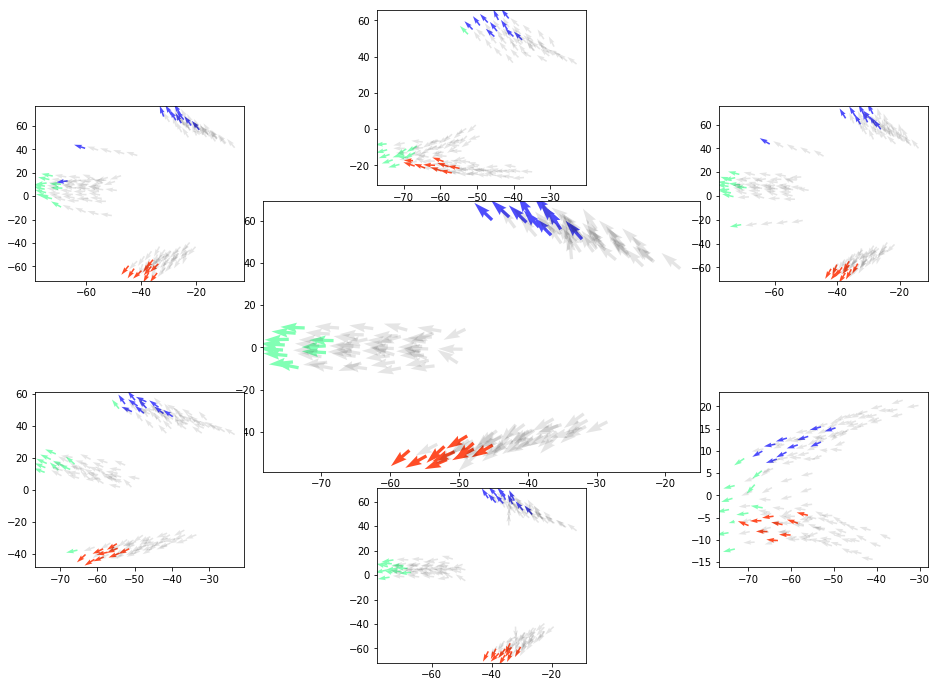

In [86]:
k = 3
predict = np.zeros((7,labels.shape[0]))

for i in range(7):
    # TODO: investigate the clusterings of nearby parameterizations
    predict[i,:] = cluster(result[i], maxT - peekIdx, k)
    # early prediction ('staining') reveals mixing

axes = flower()
cols = cm.rainbow(np.linspace(.1,.9, k))

# fix the clustering over parameter perturbation
for j in range(7):
    X = result[j].trace[0:maxT:5, :,:]; W = predict[0]
    
    for i,c in zip(range(k), cols):
        X_ = X[:, np.where(W==i+1)][:,0].T
        if not X_.shape[1] == 0:
            axes[j].quiver(*X_[:,:,-1], color=c)
            axes[j].quiver(*X_[:,:,-5:-1], alpha=.1)
            
# waiting for loss metric / ellipse repr'

###### Scratch space

In [16]:
# class Sim:
    # def plan():
        #...
        
        # me = np.copy(state[pid, :])
        # pops = np.arange(self.pop)
        # them = state[pops != pid, :]
        
        # print(norm(me[2:4]), norm(acc), speed)

In [17]:
import xarray as xr

data = xr.DataArray(sim.trace, dims=('t','id','xy'),
                    coords={'xy': ['x','y','dx','dy']})
# no magic - xarray doesn't wrangle phase space

xmin, ymin = data.isel(t=maxT-1).min(axis=0)[0:2]
xmax, ymax = data.isel(t=maxT-1).max(axis=0)[0:2]

In [18]:
# for x from sampling: forces[t,x] = sim.plan(t, x)

In [19]:
# regular samples? now we're talking xarray.
res = 20
# bias = dict(none=(0,0), left=(-1,0), right = (1,0), up=(0,1), down = (0,-1))

forces = xr.Dataset({'ddx': (('t','x','y','dx','dy'), np.zeros((maxT//zoomOut, res,res, 3,3))),
                     'ddy': (('t','x','y','dx','dy'), np.zeros((maxT//zoomOut, res,res, 3,3)))},
                     coords = {'t': np.arange(0, maxT, zoomOut),
                               'x': np.linspace(xmin, xmax, res),
                               'y': np.linspace(ymin, ymax, res),
                               'dx': [-1,0,1],
                               'dy': [-1,0,1]})
forces

<xarray.Dataset>
Dimensions:  (dx: 3, dy: 3, t: 16, x: 20, y: 20)
Coordinates:
  * t        (t) int64 0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75
  * x        (x) float64 -79.58 -77.22 -74.87 -72.51 -70.15 -67.8 -65.44 ...
  * y        (y) float64 -54.2 -47.85 -41.51 -35.17 -28.82 -22.48 -16.13 ...
  * dx       (dx) int64 -1 0 1
  * dy       (dy) int64 -1 0 1
Data variables:
    ddx      (t, x, y, dx, dy) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    ddy      (t, x, y, dx, dy) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

In [20]:
for t in forces.t:
    for x in forces.x:
        for y in forces.y:
            for dx in forces.dx:
                for dy in forces.dy:
                    st = np.array([x, y, dx, dy])
                    res = sim.plan(t, st, **sim.pars)
                    
                    forces[t,x,y,dx,dy].ddx = res[0]
                    forces[t,x,y,dx,dy].ddy = res[1]

KeyError: 0.0